Script inspired from **(C) Germans Savcisens. 22-09-2022**

# 1. Import the data

In [1]:
import tomotopy as tp
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import randrange
import spacy
import unidecode
import helpers

The data should be a csv file containing the following columns :
- "publication_date" : date of the journal, YYYY-MM-DD
- "content" : the text in the journal

In [2]:
DATA_PATH = "../data/coal_articles_es.csv"
KW = "carbon" # without accent
JOURNAL = "Imparcial"
START_DATE = pd.to_datetime("1920-01-01") ## Articles on this date WILL be included
END_DATE = pd.to_datetime("1930-01-01") ## Articles on this date WON't be included 
SPACY_LANGUAGE = "es_core_news_sm" ## To change according to the corpus, french : fr_core_news_sm

In [3]:
data = pd.read_csv(DATA_PATH, index_col="Unnamed: 0") 
#data = pd.read_csv(DATA_PATH, index_col="id") # german ones

# 2. Data Processing

In [4]:
data["publication_date"] = pd.to_datetime(data["publication_date"]) #add format='%Y' for italian ones

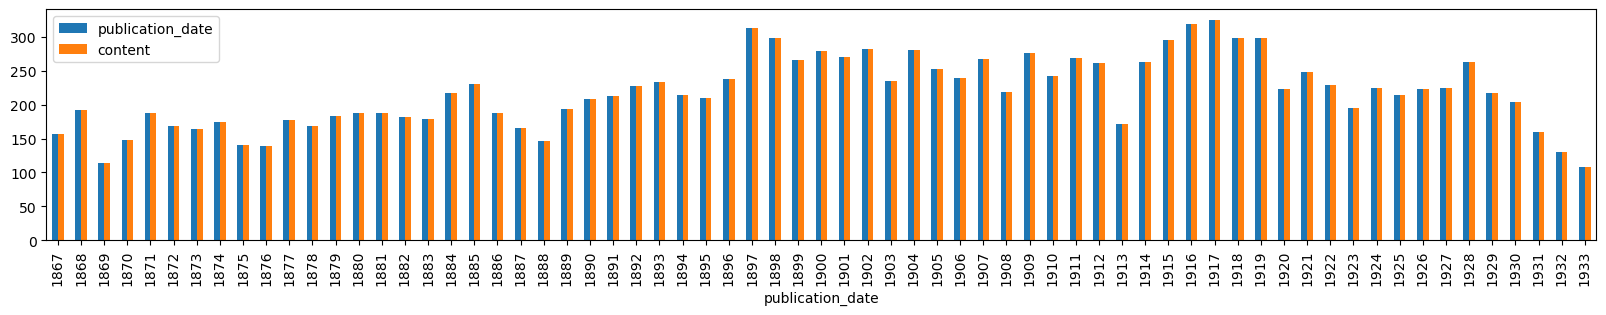

In [5]:
data.groupby(data["publication_date"].dt.year).count().plot(kind="bar", figsize=(20, 3))

In [6]:
data_filtered = helpers.load_preprocess_df(DATA_PATH, START_DATE, END_DATE, [KW], JOURNAL)
data_filtered.head(3)

,publication_date,content
imparcial_19290927,1929-09-27,"I>aís, tiende a salir de la grave crisis que ..."
imparcial_19280530,1928-05-30,"Ladrones desconocidos, utilizando riano Kiemb..."
imparcial_19290116,1929-01-16,"drama inglés"", ""Los fundamentos do u n t e a ..."


In [7]:
print("Lenght of FILTERED dataset:", len(data_filtered))

Lenght of FILTERED dataset: 2264


# 3. Topic Modelling

In [8]:
print("Create corpus for tp model...")
_, corpus = helpers.create_corpus(data_filtered, SPACY_LANGUAGE) #.sample(2000)
print("Done !")

Create corpus for tp model...
Runtime: 0.21 seconds || Completed: 1 of 2264
Runtime: 8115.55 seconds || Completed: 501 of 2264
Runtime: 29855.49 seconds || Completed: 1001 of 2264
Runtime: 38268.28 seconds || Completed: 1501 of 2264
Runtime: 38402.85 seconds || Completed: 2001 of 2264
Done !


In [9]:
############################################
###### You should change only this
k1_max = 3 ###(min 1) if k1_max - 1 == best k1
k2_max = 25
### k2 should always be higher than k1 (min 1)
####################
params = []
scores = []
num_iter = 0
max_iter = 0
for k1 in range(1, k1_max):
    for k2 in range(k1,k2_max):
        max_iter +=1
        
start = time.time()
for k1 in range(1, k1_max):
    for k2 in range(k1,k2_max):
        num_iter+=1
        model = tp.PAModel(tw=tp.TermWeight.IDF, min_df=10, rm_top=10, k1=k1, k2=k2, corpus=corpus, seed=0)
        model.train(500, workers=1)
        score = tp.coherence.Coherence(model, coherence="c_v").get_score() #try with 'u_mass' instead of 'c_v' 
        params.append((k1,k2))
        scores.append(score)
        print("Runtime: %.2f seconds" %(time.time() - start), "|| Number of Searches: %s out of  %s" %(num_iter, max_iter))

Runtime: 37.21 seconds || Number of Searches: 1 out of  47
Runtime: 83.06 seconds || Number of Searches: 2 out of  47
Runtime: 133.38 seconds || Number of Searches: 3 out of  47
Runtime: 191.16 seconds || Number of Searches: 4 out of  47
Runtime: 253.90 seconds || Number of Searches: 5 out of  47
Runtime: 320.22 seconds || Number of Searches: 6 out of  47
Runtime: 390.81 seconds || Number of Searches: 7 out of  47
Runtime: 444.77 seconds || Number of Searches: 8 out of  47
Runtime: 503.04 seconds || Number of Searches: 9 out of  47
Runtime: 566.82 seconds || Number of Searches: 10 out of  47
Runtime: 635.19 seconds || Number of Searches: 11 out of  47
Runtime: 706.61 seconds || Number of Searches: 12 out of  47
Runtime: 787.63 seconds || Number of Searches: 13 out of  47
Runtime: 869.45 seconds || Number of Searches: 14 out of  47
Runtime: 955.62 seconds || Number of Searches: 15 out of  47
Runtime: 1020.71 seconds || Number of Searches: 16 out of  47
Runtime: 1091.01 seconds || Number

(BEST MODEL) k1=1 k2=16 coherence=0.90


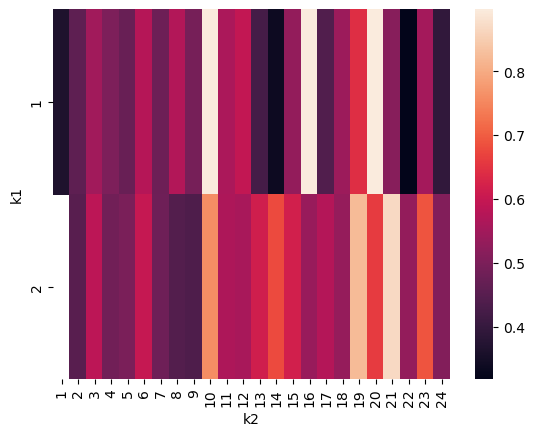

In [10]:
best_params = np.argmax(scores)
print("(BEST MODEL) k1=%s k2=%s coherence=%.2f"  %(params[best_params][0], params[best_params][1],  scores[best_params]))

data = pd.DataFrame(data={'k1':list(zip(*params))[0], 'k2':list(zip(*params))[1], 'score':scores})
data = data.pivot(index='k1', columns='k2', values='score')
sns.heatmap(data)
plt.show()

**1. Choose the best parameters**

In [11]:
#################################################
### Set the best model
best_k1 = params[best_params][0] 
best_k2 = params[best_params][1]
model = tp.PAModel(tw=tp.TermWeight.IDF, min_cf=5, k1=best_k1, k2=best_k2, corpus=corpus, seed=0)
model.burn_in=100
model.train(1000, workers=1)

**2. Print all the topics**

In [12]:
#############################################
#### Topics gonna be here 
for k in range(best_k2):
    print('Topic #{}'.format(k))
    print("\t", [w for w, _ in model.get_topic_words(k)])
        

Topic #0
	 ['kilo', 'pesetas', 'aceite', 'precio', 'fábrica', 'endo', 'venta', 'vino', 'cocina', 'céntimo']
Topic #1
	 ['mano', 'dio', 'padre', 'mujer', 'tierra', 'puerta', 'hombro', 'brazo', 'salir', 'novela']
Topic #2
	 ['toro', 'faena', 'torero', 'muleta', 'corrida', 'equipo', 'pinchazo', 'torear', 'estocada', 'valiente']
Topic #3
	 ['vendo', 'mueble', 'compro', 'consulta', 'teléfono', 'escribir', 'alhaja', 'montera', 'preciado', 'cama']
Topic #4
	 ['vida', 'hombre', 'mundo', 'querer', 'ciencia', 'idea', 'cosa', 'libro', 'dejar', 'siglo']
Topic #5
	 ['gobierno', 'país', 'millón', 'nación', 'problema', 'alemania', 'londres', 'industria', 'cuestión', 'francia']
Topic #6
	 ['doctor', 'escuela', 'exposición', 'municipal', 'universidad', 'provincial', 'edad', 'profesor', 'academia', 'servicio']
Topic #7
	 ['calle', 'josé', 'año', 'garcía', 'antonio', 'lesión', 'manuel', 'francisco', 'fernández', 'lópez']
Topic #8
	 ['ídem', 'medio', 'cuarto', 'media', 'éxito', 'orquesta', 'partido', 'est

**3. Save parameters of best model**

In [13]:
# Save parameters
param_df = pd.read_csv('../data/params.csv') 
param_df = param_df.append({"country" : DATA_PATH.split("_")[-1].split(".")[0],
          "keyword" : DATA_PATH.split("/")[-1].split("_")[0],
          "period" : (str(START_DATE.year) + "-" + str(END_DATE.year)),
          "k1" : best_k1,
          "k2" : best_k2,
          "corr" : scores[best_params]}, ignore_index=True)
param_df.to_csv('../data/params.csv', index = False)

/var/folders/2q/0m20dkz155q57k88fsjsg8b00000gn/T/ipykernel_94845/1083958019.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  param_df = param_df.append({"country" : DATA_PATH.split("_")[-1].split(".")[0],


In [14]:
df = pd.read_csv('output/params.csv')
df.tail(10)

,country,keyword,period,k1,k2,corr
85,es,steel,1900-1910,1,21,0.853575
86,es,steel,1910-1920,1,24,0.929265
87,es,steel,1920-1930,1,20,0.933438
88,es,coal,1860-1870,1,12,0.786385
89,es,coal,1870-1880,2,13,0.832676
90,es,coal,1880-1890,1,22,0.768587
91,es,coal,1890-1900,1,23,0.896573
92,es,coal,1900-1910,2,21,0.823916
93,es,coal,1910-1920,1,13,0.913935
94,es,coal,1920-1930,1,16,0.897234


**4. Compute Average Coherence**

In [15]:
df.groupby(["country", "keyword"]).mean()

/var/folders/2q/0m20dkz155q57k88fsjsg8b00000gn/T/ipykernel_94845/86344144.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(["country", "keyword"]).mean()


k1         k2      corr
country keyword                                 
de      coal       1.200000  16.000000  0.924588
        elec       1.400000  13.000000  0.725082
        steel      1.000000  14.200000  0.930735
        telegraph  1.600000  18.800000  0.804443
es      coal       1.285714  17.142857  0.845615
        elec       1.500000  19.166667  0.801458
        steel      1.285714  18.142857  0.811958
        telegraph  1.666667  21.000000  0.793348
fr      coal       2.000000  23.428571  0.746549
        elec       1.750000  15.750000  0.694521
        steel      1.400000   9.600000  0.576970
        telegraph  1.833333  18.000000  0.771936
it      coal       1.000000  14.000000  0.550378
        elec       1.500000  17.500000  0.510210
        steel      2.500000  15.000000  0.768201
        telegraph  2.000000  14.500000  0.730653
us      coal       1.400000  17.600000  0.834701
        elec       1.200000  20.400000  0.910367
        steel      1.000000  17.600000  0.932324
        telegraph  1.000000  13.000000  0.924811

In [16]:
df.groupby(["country"]).mean()

/var/folders/2q/0m20dkz155q57k88fsjsg8b00000gn/T/ipykernel_94845/614818516.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(["country"]).mean()


,k1,k2,corr
country,,,
de,1.300000,15.500000,0.846212
es,1.423077,18.769231,0.814302
fr,1.772727,17.409091,0.700746
it,1.750000,15.250000,0.639860
us,1.157895,17.368421,0.899274
